1. Problema: 
    - Encontrar os melhores clientes

3. *Descrição das Colunas do Dataset*

| Coluna       | Descrição |
|-------------|-----------|
| `invoiceno`  | Número da fatura. Um identificador único para cada transação realizada. |
| `stockcode`  | Código do produto. Um identificador único para cada item vendido. |
| `description` | Descrição do produto. O nome ou detalhes do item comprado. |
| `quantity`   | Quantidade de itens comprados em uma única transação. |
| `invoicedate` | Data e hora da compra, indicando quando a transação ocorreu. |
| `unitprice`  | Preço unitário do produto, ou seja, o valor de um único item. |
| `customerid` | Identificação do cliente. Um número único que representa cada comprador. |
| `country`    | País de origem do cliente que realizou a compra. |


1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
      - Alto Ticket Médio.*
      - Alto LTV.*
      - Baixa Recência.*
      - Alto basket size.*
      - Baixa Probabilidade de Churn.*
      - Alta Previsão LTV.*
      - Alta Propensão de Compra.*
    
    - Custo:
      - Baixa taxa de devolução.
     
     - Experiência de Compra:
       - Média Alta das Avaliação

2. Quantos clientes farão parte do grupo?
   - Número Total de Clientes
   - % do grupo Insiders
  
3. Quais as principais caracteristicas desses clientes?
    - Escrever Características do Cliente:
      - Idade
      - Localização
    - Escrever Características do Consumo.
      - Atributos da Clusterização.
  
4. Qual a porcentagem de contribuição do faturameto vinda do Insiders?
   - Faturamento total do ano
   - Faturamento do grupo Insiders
  
5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort*
  
6. Quais as condições para uma pessoa ser elegível ao Insiders?
   - Definir a periodicidade ( 1 mes, 3 meses )
   - A pessoa precisa ser similar com uma pessoa do grupo.
  
7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade ( 1 mes, 3 meses )
   - A pessoa precisa ser não similar com uma pessoa do grupo.
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
   - Teste A/B
   - Teste A/B Bayesiano
   - Teste de Hipoteses
9.  Quais ações o time de marketing pode realizar para aumentar o faturamento?  
    - Desconto
    - Preferencia de Compra

# 1.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import cluster as c
from sklearn import metrics as m
from plotly import express as px

import warnings
warnings.filterwarnings('ignore')

## 1.1 Loading Data

In [2]:
df = pd.read_csv('./data/ecommerce.csv', encoding="ISO-8859-1")
df = df.drop('Unnamed: 8', axis=1)

## 1.2 Helper Functions

In [3]:
def descriptive_analysis(num_attrs):

    # central tendency - mean, media
    ct1 = pd.DataFrame(num_attrs.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attrs.apply(np.median)).T

    # disperation - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attrs.apply(np.std)).T
    d2 = pd.DataFrame(num_attrs.apply(min)).T
    d3 = pd.DataFrame(num_attrs.apply(max)).T
    d4 = pd.DataFrame(num_attrs.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attrs.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attrs.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2,d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attrs', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    return m

# 2.0 DATA DESCRIPTION

In [4]:
df2 = df.copy()

## 2.1 Rename columns

In [5]:
df2.columns = [x.lower() for x in df2.columns]
columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df2.columns = columns
df2.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
267984,560368,22875,NUMBER TILE COTTAGE GARDEN 7,1,16-Jul-17,1.95,17841.0,United Kingdom


## 2.2 Data Dimension

In [6]:
print('Columns:', df2.shape[1])
print('Rows:', df2.shape[0])

Columns: 8
Rows: 541909


## 2.3 Data Types

In [7]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4 Check NA

In [8]:
df2.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [9]:
df2[df2['customer_id'].isna()]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,7-Dec-17,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,7-Dec-17,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,7-Dec-17,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,7-Dec-17,10.79,NaN,United Kingdom


Unfortunately, for this problem, customerid is very important. And since it is not possible to identify these columns, I will remove them. Next cycle I will tratment this problem.

## 2.5 Replace NA

In [10]:
# remove na
df2 = df2.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.0f}%'.format( ( (1-(df2.shape[0] / df.shape[0])) * 100 ))) # ( 1 - (new shape / oldest shape) ) * 100

Removed data: 25%


## 2.6 Change dtypes

In [11]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [12]:
# invoice data
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')

# customer id
df2['customer_id'] = df2['customer_id'].astype(int)

## 2.7 Descriptive Statistical

# 3.0 FEATURE ENGINEERING

In [13]:
df3 = df2.copy()

## 3.1 Feature Creation

In [14]:
df3.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [15]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'description', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [16]:
# Gross Revenue ( Faturamento ) quantity * price
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# Monetary
df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last day purchase
df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df3['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


## 3.2 Feature Selection

# 4.0 EDA ( Exploratory Data Analysis )

In [17]:
df4 = df_ref.copy()

# 5.0 Data Preparation

In [18]:
df5 = df4.copy()

# 6.0 Feature Selection

In [19]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [20]:
df7 = df6.drop(columns=['customer_id'])
X = df7.copy()

In [21]:
clusters = [2,3,4,5,6]

## 7.1 Within-Cluster Sum of Square ( WSS )

  File "C:\Users\s1294807\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


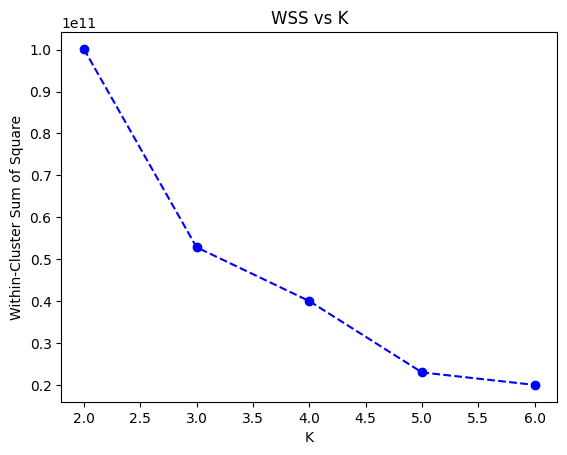

In [22]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    # model training
    kmeans.fit(X)
    # validation
    wss.append(kmeans.inertia_)
# plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

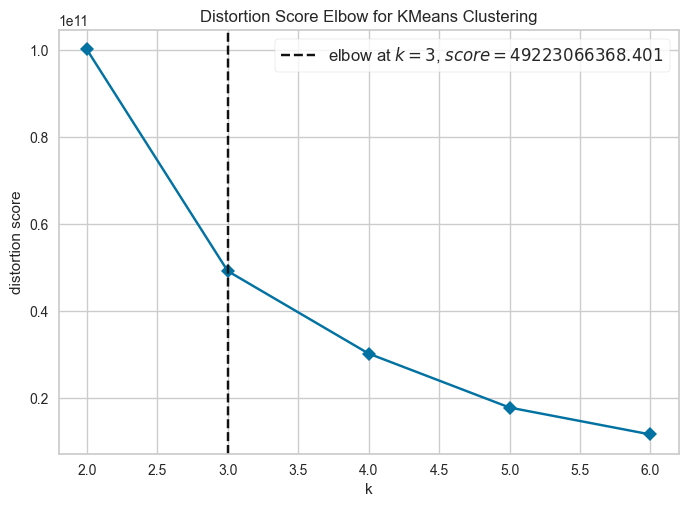

In [23]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

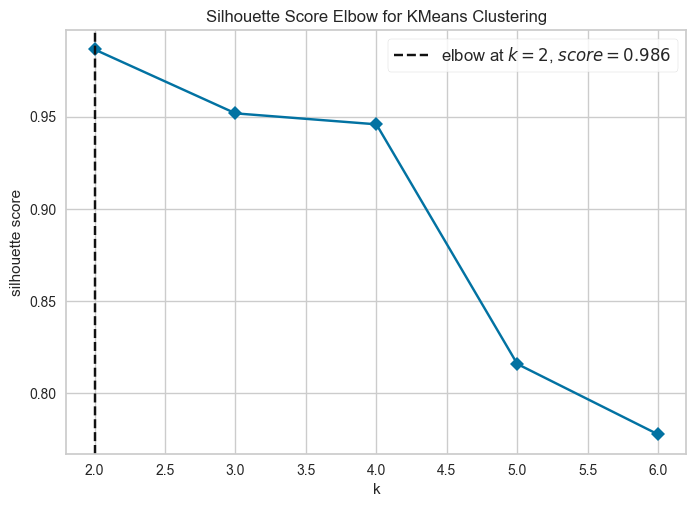

In [24]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

# 8.0 Model Training

In [25]:
df8 = df7.copy()

## 8.1 K-Means

In [26]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training 
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [27]:
print('WSS Value: {}'.format(kmeans.inertia_))
print('SS Value: {:.2f}'.format(m.silhouette_score(X, labels, metric='euclidean')))


WSS Value: 52830442008.00697
SS Value: 0.95


# 9.0 Cluster Analysis

In [28]:
df6['cluster'] = labels
df9 = df6.copy()
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,302,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0


## 9.1 Visualization Inspection

In [29]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show();

## 9.2 Cluster Profile

In [30]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,302,35,0
1,13047,3079.10,31,18,0
2,12583,7187.34,2,18,0
3,13748,948.25,95,5,0
4,15100,635.10,330,6,0


In [35]:
# number of cluster
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4335,99.153705,1372.577826,92.257901,4.614533
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,31,0.709058,40543.517742,13.290323,53.290323


# 10 Model Translation